# Multi-Agent Tensor Games Experiments

Эксперименты с многоагентными играми на тензорах, где равновесия находятся на диагонали.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch

from tensor_games import *

## 1. Создание тензорной игры для 3 агентов

In [2]:
# Создаем игру 3x3x3 для 3 агентов
game = create_diagonal_tensor_game(n_players=3, n_actions=3)

print("Тензор выплат (форма):", game.payoff_tensor.shape)
print("\nВыплаты на диагонали:")
for i in range(3):
    payoffs = game.get_payoffs([i, i, i])
    print(f"Действие ({i},{i},{i}): {payoffs}")

print("\nПримеры выплат вне диагонали:")
for actions in [(0,1,2), (1,0,2), (2,1,0)]:
    payoffs = game.get_payoffs(list(actions))
    print(f"Действие {actions}: {payoffs}")

Тензор выплат (форма): (3, 3, 3, 3)

Выплаты на диагонали:
Действие (0,0,0): [5.0, 5.0, 5.0]
Действие (1,1,1): [10.0, 10.0, 10.0]
Действие (2,2,2): [15.0, 15.0, 15.0]

Примеры выплат вне диагонали:
Действие (0, 1, 2): [2.497327922401265, 0.6370173320348285, 0.5454749016213019]
Действие (1, 0, 2): [1.822634555704315, 0.5115723710618746, 0.19515477895583855]
Действие (2, 1, 0): [0.5879485872574356, 0.1356818667316142, 0.975990992289793]


## 1.1. Визуализация тензора выплат

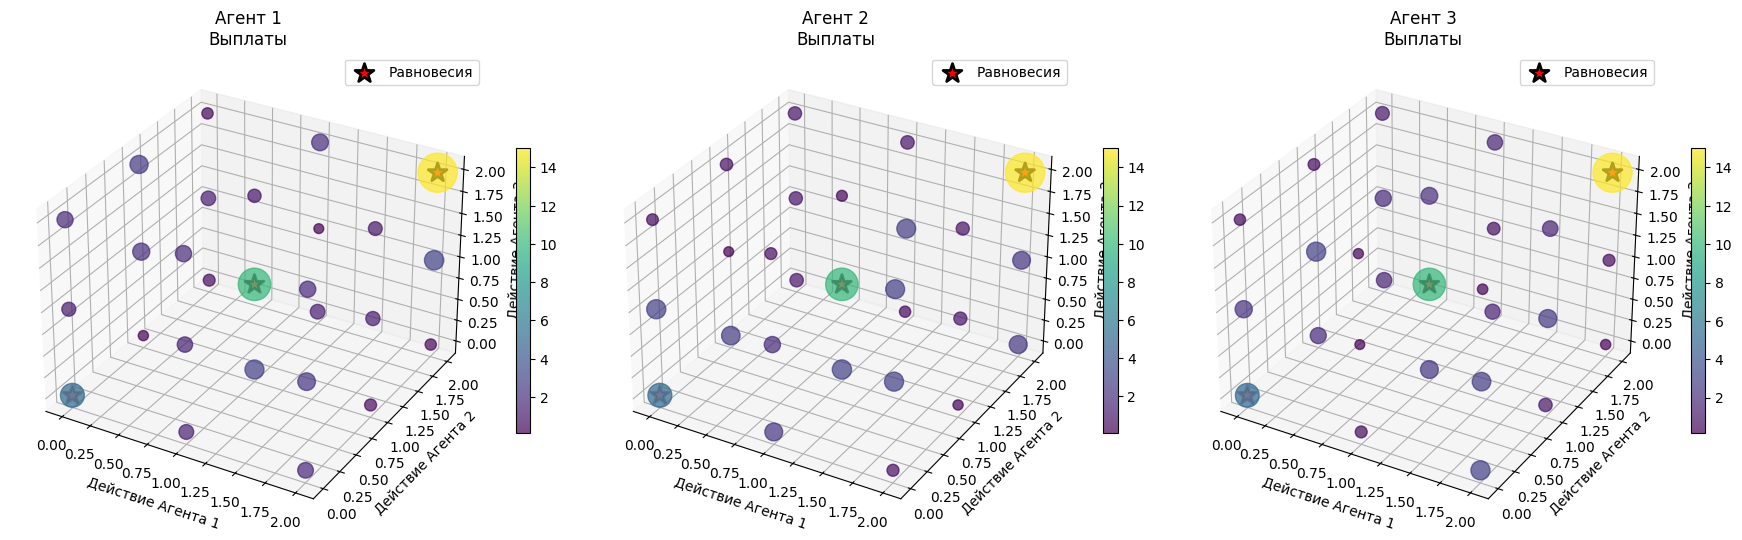

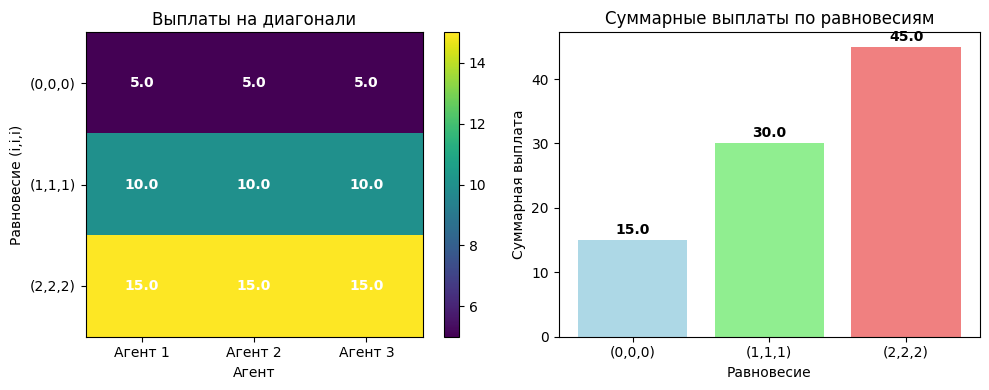

In [3]:
from mpl_toolkits.mplot3d import Axes3D

# Создаем 3D визуализацию выплат для каждого агента
fig = plt.figure(figsize=(18, 6))

# Генерируем все возможные комбинации действий
actions_grid = []
payoffs_grid = [[], [], []]  # Для каждого агента

for i in range(3):
    for j in range(3):
        for k in range(3):
            actions_grid.append([i, j, k])
            payoffs = game.get_payoffs([i, j, k])
            for agent_idx in range(3):
                payoffs_grid[agent_idx].append(payoffs[agent_idx])

actions_array = np.array(actions_grid)

# Создаем 3D scatter plot для каждого агента
colors = ['blue', 'orange', 'red']
agent_names = ['Агент 1', 'Агент 2', 'Агент 3']

for agent_idx in range(3):
    ax = fig.add_subplot(1, 3, agent_idx + 1, projection='3d')
    
    # Scatter plot с размером точек пропорциональным выплате
    payoffs_agent = np.array(payoffs_grid[agent_idx])
    sizes = (payoffs_agent - payoffs_agent.min() + 1) * 50
    
    scatter = ax.scatter(actions_array[:, 0], actions_array[:, 1], actions_array[:, 2],
                        c=payoffs_agent, s=sizes, alpha=0.7, cmap='viridis')
    
    # Выделяем диагональные элементы
    diagonal_mask = (actions_array[:, 0] == actions_array[:, 1]) & \
                   (actions_array[:, 1] == actions_array[:, 2])
    diagonal_actions = actions_array[diagonal_mask]
    diagonal_payoffs = payoffs_agent[diagonal_mask]
    
    ax.scatter(diagonal_actions[:, 0], diagonal_actions[:, 1], diagonal_actions[:, 2],
              c='red', s=200, marker='*', edgecolors='black', linewidth=2,
              label='Равновесия')
    
    ax.set_xlabel('Действие Агента 1')
    ax.set_ylabel('Действие Агента 2')
    ax.set_zlabel('Действие Агента 3')
    ax.set_title(f'{agent_names[agent_idx]}\nВыплаты')
    
    # Добавляем colorbar
    plt.colorbar(scatter, ax=ax, shrink=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

# Дополнительная heatmap для диагональных элементов
plt.figure(figsize=(10, 4))

diagonal_payoffs_matrix = np.zeros((3, 3))
for i in range(3):
    payoffs = game.get_payoffs([i, i, i])
    diagonal_payoffs_matrix[i, :] = payoffs

plt.subplot(1, 2, 1)
im = plt.imshow(diagonal_payoffs_matrix, cmap='viridis', aspect='auto')
plt.title('Выплаты на диагонали')
plt.xlabel('Агент')
plt.ylabel('Равновесие (i,i,i)')
plt.xticks([0, 1, 2], ['Агент 1', 'Агент 2', 'Агент 3'])
plt.yticks([0, 1, 2], ['(0,0,0)', '(1,1,1)', '(2,2,2)'])
plt.colorbar(im)

# Добавляем значения на heatmap
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{diagonal_payoffs_matrix[i,j]:.1f}',
                ha='center', va='center', color='white', fontweight='bold')

# График суммарных выплат
plt.subplot(1, 2, 2)
total_payoffs = diagonal_payoffs_matrix.sum(axis=1)
plt.bar(range(3), total_payoffs, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Суммарные выплаты по равновесиям')
plt.xlabel('Равновесие')
plt.ylabel('Суммарная выплата')
plt.xticks(range(3), ['(0,0,0)', '(1,1,1)', '(2,2,2)'])

# Добавляем значения на столбцы
for i, v in enumerate(total_payoffs):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Эксперимент: взлом payoff третьим агентом

In [4]:
# Создаем агентов с разными стратегиями
# Агенты 1 и 2: Adam + exploration (жертвы)
# Агент 3: Adversarial agent (атакующий)

from tensor_games import AdversarialAgent

agent1 = MultiAgent(n_actions=3, lr=0.01, epsilon=0.2, optimizer_type='Adam')
agent2 = MultiAgent(n_actions=3, lr=0.01, epsilon=0.2, optimizer_type='Adam')
agent3 = AdversarialAgent(n_actions=3, lr=0.01, epsilon=0.0, optimizer_type='Adam')

agents = [agent1, agent2, agent3]

print("Конфигурация агентов:")
print("Агент 1: Adam, epsilon=0.2 (жертва)")
print("Агент 2: Adam, epsilon=0.2 (жертва)")
print("Агент 3: Adversarial Agent (атакующий loss других агентов)")

Конфигурация агентов:
Агент 1: Adam, epsilon=0.2
Агент 2: Adam, epsilon=0.2
Агент 3: Adam, epsilon=0.0 (эксплуататор)


In [5]:
# Обучение агентов
print("Начинаем обучение...")
history = train_multi_agents(game, agents, n_episodes=5000)

# Получаем финальные стратегии
final_strategies = [agent.get_action_probs() for agent in agents]

print("\nФинальные стратегии:")
for i, strategy in enumerate(final_strategies):
    print(f"Агент {i+1}: {strategy}")

# Анализ результатов
final_rewards = np.mean(history[-100:], axis=0)
print(f"\nСредние награды за последние 100 эпизодов:")
for i, reward in enumerate(final_rewards):
    print(f"Агент {i+1}: {reward:.3f}")
print(f"Общая сумма: {sum(final_rewards):.3f}")

Начинаем обучение...
Episode 0: Avg rewards ['2.961', '2.317', '0.596']
Episode 1000: Avg rewards ['10.090', '10.066', '9.969']
Episode 2000: Avg rewards ['11.598', '11.566', '11.530']
Episode 3000: Avg rewards ['11.325', '11.278', '11.254']
Episode 4000: Avg rewards ['11.387', '11.426', '11.175']

Финальные стратегии:
Агент 1: [0.03408669 0.02816907 0.93774426]
Агент 2: [0.01651158 0.00750835 0.97598004]
Агент 3: [7.4542322e-07 8.8042816e-07 9.9999833e-01]

Средние награды за последние 100 эпизодов:
Агент 1: 10.628
Агент 2: 10.552
Агент 3: 10.557
Общая сумма: 31.738


## 3. Визуализация результатов

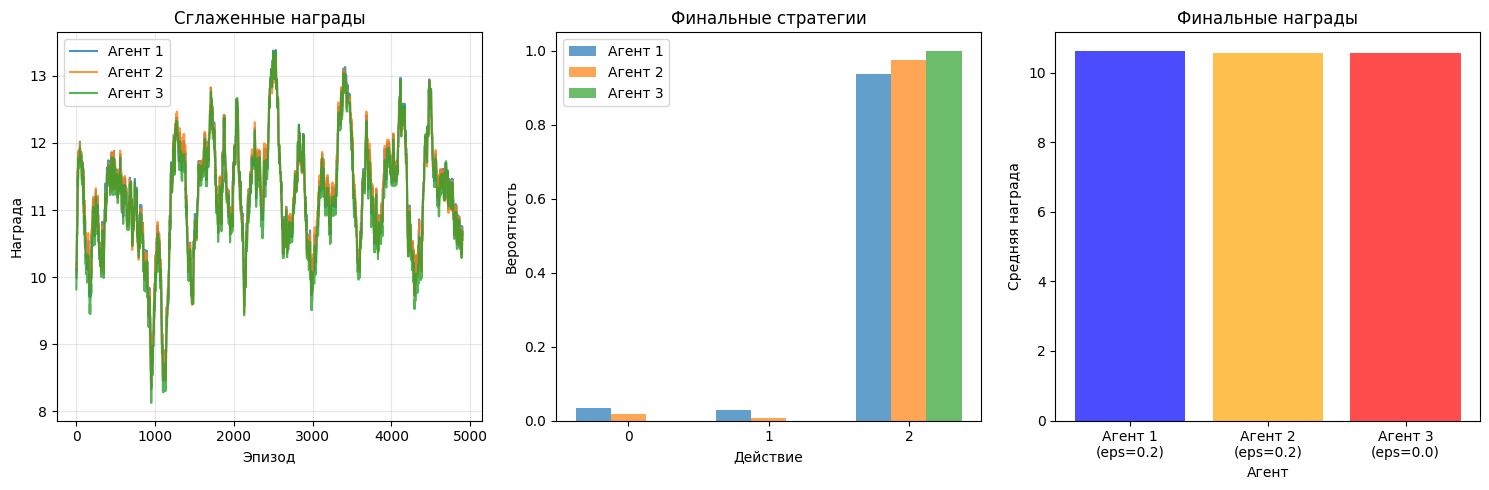

In [6]:
# График обучения
plt.figure(figsize=(15, 5))

# Награды по времени
plt.subplot(1, 3, 1)
history_array = np.array(history)
window = 100

for i in range(3):
    smooth_rewards = np.convolve(history_array[:, i], np.ones(window)/window, mode='valid')
    plt.plot(smooth_rewards, label=f'Агент {i+1}', alpha=0.8)

plt.title('Сглаженные награды')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True, alpha=0.3)

# Финальные стратегии
plt.subplot(1, 3, 2)
x = np.arange(3)
width = 0.25

for i, strategy in enumerate(final_strategies):
    plt.bar(x + i*width, strategy, width, label=f'Агент {i+1}', alpha=0.7)

plt.title('Финальные стратегии')
plt.xlabel('Действие')
plt.ylabel('Вероятность')
plt.legend()
plt.xticks(x + width, ['0', '1', '2'])

# Распределение наград
plt.subplot(1, 3, 3)
final_rewards_list = [final_rewards[i] for i in range(3)]
colors = ['blue', 'orange', 'red']
plt.bar(range(3), final_rewards_list, color=colors, alpha=0.7)
plt.title('Финальные награды')
plt.xlabel('Агент')
plt.ylabel('Средняя награда')
plt.xticks(range(3), ['Агент 1\n(eps=0.2)', 'Агент 2\n(eps=0.2)', 'Агент 3\n(eps=0.0)'])

plt.tight_layout()
plt.show()

## 4. Анализ эксплуатации

In [7]:
# Проверяем, удалось ли третьему агенту эксплуатировать других
print("Анализ эксплуатации:")
print("\nТеоретические равновесия на диагонали:")
for i in range(3):
    payoffs = game.get_payoffs([i, i, i])
    print(f"({i},{i},{i}): {payoffs} (сумма: {sum(payoffs)})")

print("\nФактическое поведение агентов:")
most_likely_actions = [np.argmax(strategy) for strategy in final_strategies]
print(f"Наиболее вероятные действия: {most_likely_actions}")

if len(set(most_likely_actions)) == 1:
    print("✓ Агенты сошлись к одному действию (координация)")
    equilibrium_idx = most_likely_actions[0]
    expected_payoffs = game.get_payoffs([equilibrium_idx] * 3)
    print(f"Ожидаемые выплаты в равновесии: {expected_payoffs}")
else:
    print("✗ Агенты не достигли координации")
    actual_payoffs = game.get_payoffs(most_likely_actions)
    print(f"Фактические выплаты: {actual_payoffs}")

# Проверяем, получил ли третий агент преимущество
if final_rewards[2] > max(final_rewards[0], final_rewards[1]):
    advantage = final_rewards[2] - max(final_rewards[0], final_rewards[1])
    print(f"\n🎯 Агент 3 успешно эксплуатировал других! Преимущество: {advantage:.3f}")
else:
    print(f"\n❌ Агент 3 не смог получить преимущество")

print(f"\nСравнение с оптимальным равновесием (2,2,2):")
optimal_payoffs = game.get_payoffs([2, 2, 2])
print(f"Оптимальные выплаты: {optimal_payoffs}")
print(f"Фактические выплаты: {[f'{r:.3f}' for r in final_rewards]}")

Анализ эксплуатации:

Теоретические равновесия на диагонали:
(0,0,0): [5.0, 5.0, 5.0] (сумма: 15.0)
(1,1,1): [10.0, 10.0, 10.0] (сумма: 30.0)
(2,2,2): [15.0, 15.0, 15.0] (сумма: 45.0)

Фактическое поведение агентов:
Наиболее вероятные действия: [np.int64(2), np.int64(2), np.int64(2)]
✓ Агенты сошлись к одному действию (координация)
Ожидаемые выплаты в равновесии: [15.0, 15.0, 15.0]

❌ Агент 3 не смог получить преимущество

Сравнение с оптимальным равновесием (2,2,2):
Оптимальные выплаты: [15.0, 15.0, 15.0]
Фактические выплаты: ['10.628', '10.552', '10.557']
